In [2]:
# import libraries 
from scipy import sparse
import pickle
import pandas as pd
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import log_loss
import joblib
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB

In [6]:
# load the data
X_train = sparse.load_npz(r'C:\Users\Wenxia\Desktop\Python\Airbnb_prediction\data\X_train.npz')
X_cv = sparse.load_npz(r'C:\Users\Wenxia\Desktop\Python\Airbnb_prediction\data\X_cv.npz')
X_test = sparse.load_npz(r'C:\Users\Wenxia\Desktop\Python\Airbnb_prediction\data\X_test.npz')

In [7]:
Y_train = pd.read_pickle(r'C:\Users\Wenxia\Desktop\Python\Airbnb_prediction\data\Y_train.pickle')
Y_cv = pd.read_pickle(r'C:\Users\Wenxia\Desktop\Python\Airbnb_prediction\data\Y_cv.pickle')

In [8]:
with open(r'C:\Users\Wenxia\Desktop\Python\Airbnb_prediction\data\final_column_list.text', 'rb') as fp:
    final_column_list = pickle.load(fp)

In [9]:
print("Final dataset :")
print("Train dataset:", X_train.shape)
print("CV dataset:", X_cv.shape)
print("Test dataset:", X_test.shape)
print("="*100)
print("Total Number of columns:", len(final_column_list))
print("Target train variable count:", Y_train.shape)
print("Target cv variable count:", Y_cv.shape)

Final dataset :
Train dataset: (59052, 624)
CV dataset: (14763, 624)
Test dataset: (61668, 624)
Total Number of columns: 617
Target train variable count: (59052,)
Target cv variable count: (14763,)


In [10]:
le = LabelEncoder()
Y_train = le.fit_transform(Y_train)
Y_train

array([10,  7,  7, ...,  7, 10, 10])

In [8]:
Y_cv = le.fit_transform(Y_cv)
Y_cv

array([ 7,  7,  7, ..., 10, 11, 10])

In [11]:
# save test id from X_test file 

test_df = pd.read_csv(r'C:\Users\Wenxia\Desktop\Python\Airbnb_prediction\data\test_user_merged.csv')
test_id = test_df['id'].values
print(test_id)

['5uwns89zht' 'jtl0dijy2j' 'xx0ulgorjt' ... 'fa6260ziny' '87k0fy4ugm'
 '9uqfg8txu3']


## 1. Logistic Regression Model 

In [22]:
params = {'C': [0.0001, 0.001, 0.01, 0.1]}
lr = linear_model.LogisticRegression(multi_class = 'multinomial', solver='lbfgs')
clf_lr = RandomizedSearchCV(lr, params, verbose = 1, n_iter= 3, n_jobs=1, scoring = 'neg_log_loss')

In [23]:
clf_lr.fit(X_train, Y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


c:\Users\Wenxia\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Wenxia\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

RandomizedSearchCV(estimator=LogisticRegression(multi_class='multinomial'),
                   n_iter=3, n_jobs=1,
                   param_distributions={'C': [0.0001, 0.001, 0.01, 0.1]},
                   scoring='neg_log_loss', verbose=1)

In [24]:
clf_lr.best_estimator_

LogisticRegression(C=0.1, multi_class='multinomial')

In [25]:
pred_Y_train = clf_lr.predict_proba(X_train)

In [26]:
train_log_loss_lr = log_loss(Y_train, pred_Y_train)
train_log_loss_lr

1.6317140991984407

In [27]:
pred_Y_cv = clf_lr.predict_proba(X_cv)

In [28]:
cv_log_loss_lr = log_loss(Y_cv, pred_Y_cv)
cv_log_loss_lr

1.6151747540829202

In [29]:
pred_Y_test = clf_lr.predict_proba(X_test)

In [32]:
print(pred_Y_test.shape)
type(pred_Y_test)

(61668, 12)


numpy.ndarray

In [33]:
# extract the predictd result in csv
ids = []
countries = []

for i in range(len(test_id)-1):
    idx = test_id[i]
    ids += [idx]*5
    countries += le.inverse_transform(np.argsort(pred_Y_test[i])[::-1][:5]).tolist()

sub = pd.DataFrame({"id": ids, "country": countries})
sub.to_csv(r'C:\Users\Wenxia\Desktop\Python\Airbnb_prediction\data\lr_submission.csv', index=False)

In [34]:
# save the LR model
joblib.dump(clf_lr, r'C:\Users\Wenxia\Desktop\Python\Airbnb_prediction\clf_lr')

['C:\\Users\\Wenxia\\Desktop\\Python\\Airbnb_prediction\\clf_lr']

## 2. Random Forest Model

In [36]:
# random forest
params = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [10, 20, 30, 50],
    'min_samples_split': [2 ,5, 10],
    'min_samples_leaf': [1, 2, 5, 10]
}
rf = RandomForestClassifier()

clf_rf = RandomizedSearchCV(rf, params, verbose=2, n_jobs=-1, scoring='neg_log_loss')


In [37]:
clf_rf.fit(X_train, Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 50],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 500, 1000]},
                   scoring='neg_log_loss', verbose=2)

In [64]:
clf_rf.best_estimator_

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=1000)

In [65]:
pred_Y_train = clf_rf.predict_proba(X_train)

In [66]:
train_log_loss_rf = log_loss(Y_train, pred_Y_train)
train_log_loss_rf

0.6228857682070473

In [67]:
pred_Y_cv = clf_rf.predict_proba(X_cv)

In [68]:
cv_log_loss_rf = log_loss(Y_cv, pred_Y_cv)
cv_log_loss_rf

0.9921776445875651

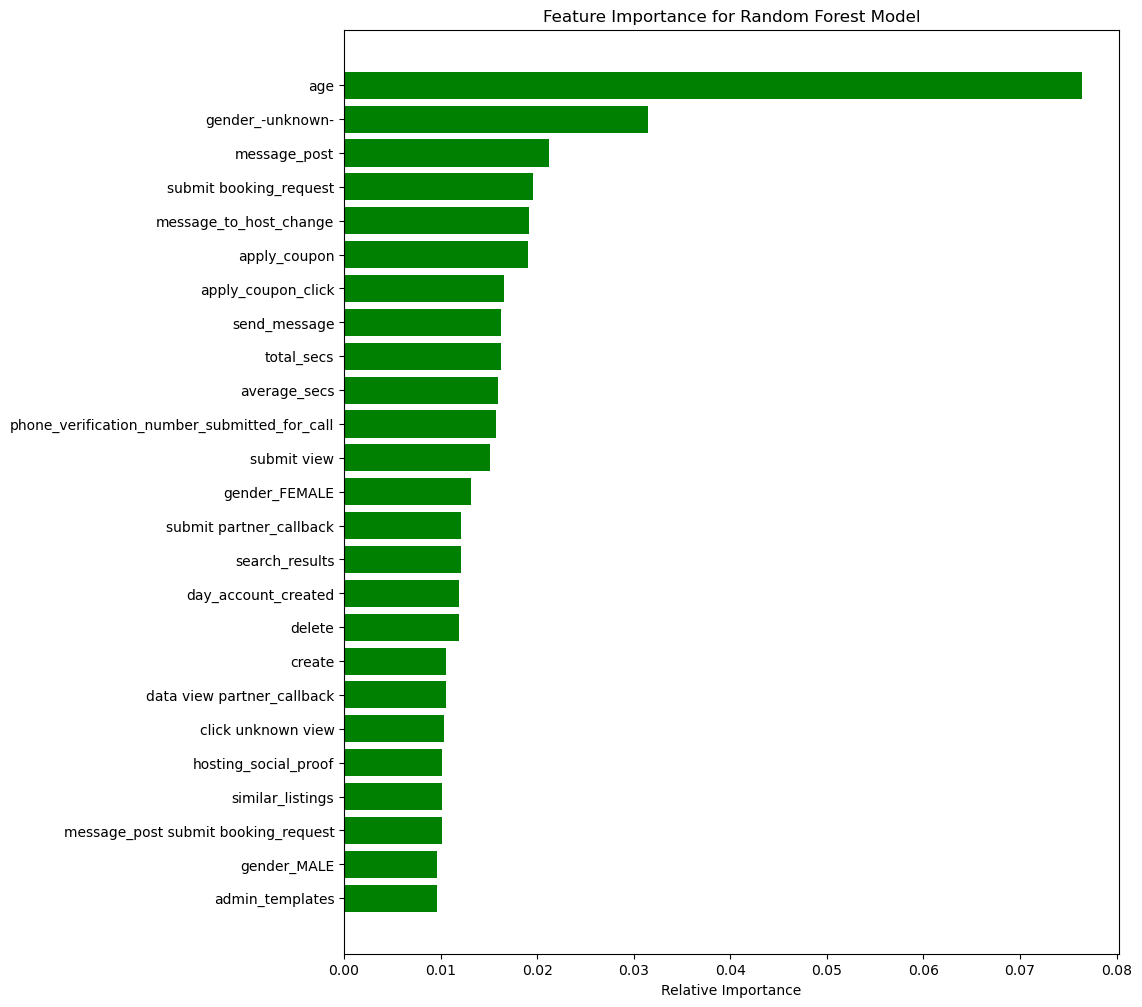

In [74]:
# Feature importance for random forest model
features = final_column_list
importances = clf_rf.best_estimator_.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importance for Random Forest Model')
plt.barh(range(len(indices)), importances[indices], color = 'g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.savefig(r"C:\Users\Wenxia\Desktop\Python\Airbnb_prediction\data\feature_importance_rf.png", dpi=300, bbox_inches="tight")
plt.show()

In [75]:
results_rf = clf_rf.cv_results_
x_axis = np.array(results_rf['param_n_estimators'].data, dtype=float)
y_axis = np.array(results_rf['param_max_depth'].data, dtype=float)

In [76]:
pvt_test = pd.DataFrame(results_rf)
pvt_test.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,715.968603,1.699682,2.075226,0.098280,200,2,1,50,"{'n_estimators': 200, 'min_samples_split': 2, ...",-1.340182,-1.279118,-1.258788,-1.280307,-1.254492,-1.282577,0.030627,10
1,163.780117,4.436974,3.200164,0.544574,500,10,10,10,"{'n_estimators': 500, 'min_samples_split': 10,...",-0.971110,-0.969409,-0.964212,-0.969247,-0.968692,-0.968534,0.002307,6
2,463.497689,4.579173,1.763948,0.035168,200,2,2,50,"{'n_estimators': 200, 'min_samples_split': 2, ...",-1.012004,-1.027908,-0.995680,-1.012780,-0.999159,-1.009506,0.011435,9
3,1007.037550,14.395181,8.217848,1.465410,1000,10,10,20,"{'n_estimators': 1000, 'min_samples_split': 10...",-0.953044,-0.954499,-0.947414,-0.949963,-0.950779,-0.951140,0.002462,3
4,658.372988,10.100037,3.782951,0.362886,500,10,1,20,"{'n_estimators': 500, 'min_samples_split': 10,...",-0.953947,-0.954505,-0.946859,-0.949831,-0.950475,-0.951123,0.002817,2


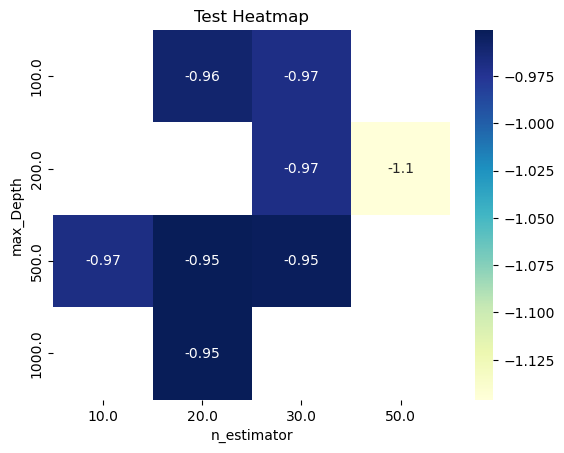

In [78]:
pvt_test = pd.pivot_table(pd.DataFrame(results_rf), values='mean_test_score', index=x_axis, columns=y_axis)
sns.heatmap(pvt_test, annot=True, cmap='YlGnBu')
plt.xlabel('n_estimator') 
plt.ylabel('max_Depth')
plt.title('Test Heatmap')
plt.savefig(r"C:\Users\Wenxia\Desktop\Python\Airbnb_prediction\data\heat_map_rf.png", dpi=300, bbox_inches="tight")
plt.show()

In [22]:
pred_Y_test = clf_rf.predict_proba(X_test)
print(pred_Y_test.shape)
print(pred_Y_test[1])

(61668, 12)
[1.19426583e-03 5.87675895e-03 2.54624529e-03 8.21430967e-03
 1.69985219e-02 4.52920127e-03 8.37603572e-03 6.50017875e-01
 2.41415547e-03 2.13191896e-04 2.56563088e-01 4.30563514e-02]


In [23]:
ids = []
countries = []

for i in range(len(test_id)-1): 
    idx = test_id[i]
    ids += [idx]*5
    countries += le.inverse_transform(np.argsort(pred_Y_test)[i][::-1][:5]).tolist()

In [24]:
sub = pd.DataFrame({"id": ids, "country": countries})

In [ ]:
sub.to_csv(r'C:\Users\Wenxia\Desktop\Python\Airbnb_prediction\data\rf_submission.csv', index=False)

In [49]:
joblib.dump(clf_rf, r'C:\Users\Wenxia\Desktop\Python\Airbnb_prediction\clf_rf')

['C:\\Users\\Wenxia\\Desktop\\Python\\Airbnb_prediction\\clf_rf']

## 3. Xgboost Model

In [50]:
param_grid = {
    'max_depth': [5, 10, 15],
    'n_estimators': [100, 200, 300]
}

xgb = xgb.XGBClassifier(objective='multi:softmax', eval_metric='mlogloss')
clf_xgb = RandomizedSearchCV(xgb, param_grid, n_jobs=-1, verbose=2, scoring='neg_log_loss')

In [51]:
clf_xgb.fit(X_train, Y_train)

c:\Users\Wenxia\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 9 candidates, totalling 45 fits


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rat...
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           objective='multi:softmax', ...),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15],
                                        'n_estimators': [100, 200, 300]},
                   scoring='neg_log_loss', verbose=2)

In [30]:
clf_xgb.best_params_

{'n_estimators': 100, 'max_depth': 5}

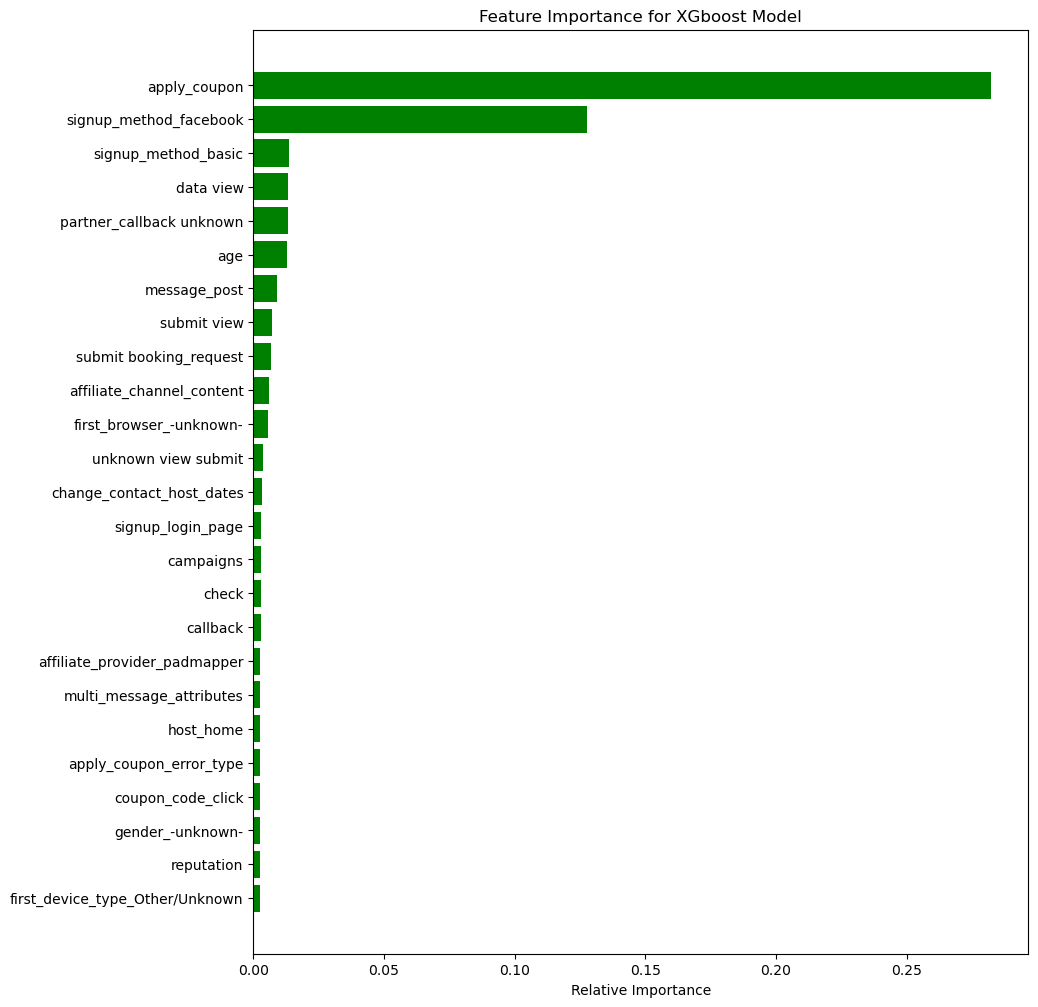

In [31]:
# Feature importance for random forest model
features = final_column_list
importances = clf_xgb.best_estimator_.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importance for XGboost Model')
plt.barh(range(len(indices)), importances[indices], color = 'g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [32]:
results_xgb = clf_xgb.cv_results_
x_axis = np.array(results_xgb['param_n_estimators'].data, dtype=float)
y_axis = np.array(results_xgb['param_max_depth'].data, dtype=float)

Text(0.5, 1.0, 'CV NDCG Heatmap')

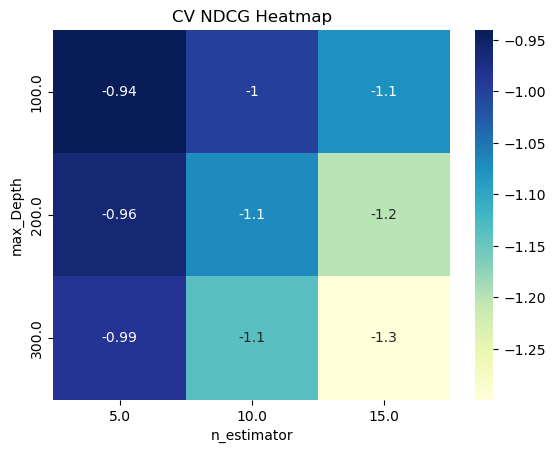

In [34]:
pvt_test = pd.pivot_table(pd.DataFrame(results_xgb), values='mean_test_score', index=x_axis, columns=y_axis)
sns.heatmap(pvt_test, annot=True, cmap='YlGnBu')
plt.xlabel('n_estimator') 
plt.ylabel('max_Depth')
plt.title('CV NDCG Heatmap')

In [35]:
pred_Y_train = clf_xgb.predict_proba(X_train)

In [36]:
train_log_loss_xgb = log_loss(Y_train, pred_Y_train)
train_log_loss_xgb

0.6945650048856856

In [37]:
pred_Y_cv = clf_xgb.predict_proba(X_cv)
cv_log_loss_xgb = log_loss(Y_cv, pred_Y_cv)
cv_log_loss_xgb

1.055470205890205

In [38]:
pred_Y_test = clf_xgb.predict_proba(X_test)

In [39]:
ids = []
countries = []

for i in range(len(test_id)-1): 
    idx = test_id[i]
    ids += [idx]*5
    countries += le.inverse_transform(np.argsort(pred_Y_test)[i][::-1][:5]).tolist()

In [40]:
sub = pd.DataFrame({"id": ids, "country": countries})
print(sub.head())

           id country
0  5uwns89zht     NDF
1  5uwns89zht      US
2  5uwns89zht   other
3  5uwns89zht      FR
4  5uwns89zht      IT


In [41]:
sub.to_csv(r'C:\Users\Wenxia\Desktop\Python\Airbnb_prediction\data\xgb_submission.csv', index=False)

In [42]:
joblib.dump(clf_xgb, r'C:\Users\Wenxia\Desktop\Python\Airbnb_prediction\clf_xgb')

['C:\\Users\\Wenxia\\Desktop\\Python\\Airbnb_prediction\\clf_xgb']

## 4. Naive Bayes Model 

In [54]:
params = {'alpha': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 0.5, 1, 5, 10, 50, 100]}
nb = MultinomialNB()
clf_nb = RandomizedSearchCV(nb, params, verbose=1, n_iter=20, n_jobs=-1, scoring="neg_log_loss")

In [55]:
clf_nb.fit(X_train, Y_train)

c:\Users\Wenxia\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 12 candidates, totalling 60 fits


RandomizedSearchCV(estimator=MultinomialNB(), n_iter=20, n_jobs=-1,
                   param_distributions={'alpha': [1e-06, 1e-05, 0.0001, 0.001,
                                                  0.01, 0.1, 0.5, 1, 5, 10, 50,
                                                  100]},
                   scoring='neg_log_loss', verbose=1)

In [56]:
clf_nb.best_estimator_

MultinomialNB(alpha=100)

In [57]:
pred_Y_train = clf_nb.predict_proba(X_train)
train_log_loss_nb = log_loss(Y_train, pred_Y_train)
train_log_loss_nb

26.373800244118254

In [58]:
pred_Y_cv = clf_nb.predict_proba(X_cv)
cv_log_loss_nb = log_loss(Y_cv, pred_Y_cv)
cv_log_loss_nb

26.526772871389717

In [59]:
pred_Y_test =clf_nb.predict_proba(X_test)

In [62]:
ids = []
countries = []

for i in range(len(test_id)-1): 
    idx = test_id[i]
    ids += [idx]*5
    countries += le.inverse_transform(np.argsort(pred_Y_test)[i][::-1][:5]).tolist()

sub = pd.DataFrame({"id": ids, "country": countries})

In [ ]:
sub.to_csv(r'C:\Users\Wenxia\Desktop\Python\Airbnb_prediction\data\nb_submission.csv', index=False)

joblib.dump(clf_rf, r'C:\Users\Wenxia\Desktop\Python\Airbnb_prediction\clf_nb')